# How does the UK housing market change in Greater London Area over 5-year period within purchase transactions of freehold and leasehold estate for detached, terraced, semi-detached property and flats before and after implementation of First Time Buyers’ (FTB) Relief?


## Introduction

The Great Recession in 2008 demonstrated how changes to the housing market have not only economic but also social consequences. John Bone and Karen O'Reilly (2010) suggest that the recent trend of viewing the purchase of property as a means of investment rather than a primary place to live contributes to growing housing unaffordability. This socio-economic issue specifically concerns younger people who do not come from a privileged background and do not have substantial savings to enter the housing market. According to Nissa Finney and Albert Sabater(2022), as housing in certain areas of England and Wales becomes less affordable, it causes a generational divide in housing opportunities. Age segregation becomes more prominent, presenting challenges to social mobility.

Additionally, John Bone and Karen O'Reilly (2010) mention how a larger number of individuals owning a stable home results in more sustainable communities and benefits the overall wellbeing of many families. According to Nikodem Szumilo (2018), accessible homeownership would not necessarily change wages but might potentially have positive implications for increased economic activity. Therefore, governments should consider how their policies affect demand and supply in the housing market. In 2017, the UK government announced a new policy, the First Time Buyers' (FTB) Relief, which exempted buyers from paying a Stamp Duty Land Tax (SDLT) on an acquired house with a value of less than 300 thousand pounds and removed property tax from house purchases valued less than 500 thousand. This policy should have increased affordability for those who considered buying their first home (Bolster, 2011).

This analysis uses the data provided by HM Land Registry, the non-ministerial department that monitors and documents every housing transaction in England and Wales and has an open database for all purchases since 1995(HM Land Registry Open Data, 2023). This research paper attempts to evaluate how the FTB Relief influenced market prices and what difference it made for properties of different ages, types, and estates. Therefore, the exploration is limited to only 5 years with all property transactions between March 2015 and March 2020, as the COVID-19 pandemic disrupted the economy overall. This research focuses on the Greater London area, the most populated English county that accounts for almost 13% of all property transactions in England and Wales.

This paper highlights how prices of detached houses purchased are substantially more expensive and the average is more volatile compared to other types of property between March 2015 and March 2020. Most of the property purchased in Greater London had a price of less than 600 thousand pounds. Within the same time period, the mean housing price increased every year, except for a year between March 2018 and March 2019, which experienced a significant price drop. The comparison for growth rates in prices between old and new property demonstrates that there was an increase in the values of new property purchased for the last 3 years, with a spike in growth between March 2017 and March 2018.


## Data Cleaning

The dataset used in this research includes 16 variables: Transaction Identifier (each purchase has a unique value), Price Paid, Date of Transfer, Postcode, Property Type, New Build status, Tenure, Primary Address (PAON), Secondary Address (SAON), Street, Locality, City or Town, District, County, PPD_Category Type, and Record Status(HM Land Registry Open Data, 2023). All address variables indicate the location of the sold property. Property Type specifies if it's a flat (F), detached (D), semi-detached (S), or terraced (T) house, or other type of property (O). Tenure ('Duration') can be freehold (F) or leasehold (L), a trait common in the housing market of common law countries. PPD_Category indicates whether the purchase was a Standard Price Paid entry (A) or an Additional Price Paid entry (B).

The research question focuses on the period from March 2015 to March 2020, so transactions outside this timeframe are excluded. The analysis is centered on residential properties, thus only transactions for detached, semi-detached, terraced houses, and flats are considered. The filtering process removes PAON, SAON, and Record Status columns, and data where the Tenure type is unknown, as they are irrelevant to the research question. It also excludes all purchases made outside of the Greater London Area, as it is the primary region of interest.

For this research, changes in the Greater London Area's housing market can be analyzed through changes in property prices, thereby making it the dependent variable. Independent variables that could potentially affect it include Date of Transfer, Property Type, Tenure, and Old/New (property age). All entries with missing price values are removed, however, there are none.

These variables are significant in this research because they could potentially indicate different dynamics based on socio-economic factors, as areas typically have a higher concentration of specific housing types. This also expands the potential for future research.

In [1]:
import numpy as np
import pandas as pd 
import os

In [2]:
dataset_path = "/Users/user/Desktop/ECO225/ECO225Project/Data/202304.csv"

colnames = ['Transaction_unique_identifier', 'price', 'Date_of_Transfer', 
            'postcode', 'Property_Type', 'Old/New', 
            'Duration', 'PAON', 'SAON', 
            'Street', 'Locality', 'Town/City', 
            'District', 'County', 'PPDCategory_Type',
            'Record_Status - monthly_file_only']

In [3]:
# Read the dataset in chunks
chunk_size = 10000
df_chunks = pd.read_csv(dataset_path, header=None, names=colnames, chunksize=chunk_size)

In [4]:
#Convert "Date_of_Transfer" to year and month
df = pd.concat([chunk.assign(Year_of_Transfer=pd.to_datetime(chunk['Date_of_Transfer']).dt.year,
                             Month_of_Transfer=pd.to_datetime(chunk['Date_of_Transfer']).dt.month) 
                for chunk in df_chunks])

In [5]:
df = df[((df['Year_of_Transfer'] == 2015) & (df['Month_of_Transfer'] >= 3)) |
        ((df['Year_of_Transfer'] > 2015) & (df['Year_of_Transfer'] < 2020)) |
        ((df['Year_of_Transfer'] == 2020) & (df['Month_of_Transfer'] < 3))]

In [6]:
county_to_keep = 'GREATER LONDON'

In [7]:
property_types_to_keep = ['D', 'S', 'T', 'F']

In [8]:
df = df[df['Property_Type'].isin(property_types_to_keep) & (df['County'] == county_to_keep)]

In [9]:
df = df[(df['Duration'] != 'U')]

In [10]:
# Remove unnecessary columns
columns_to_remove = ['PAON', 'SAON', 'Record_Status - monthly_file_only']
df = df.drop(columns=columns_to_remove)

In [11]:
groupby_vars = ['Property_Type', 'Old/New', 'Duration', 'Year_of_Transfer', 'Month_of_Transfer', 'County']

In [12]:
#Create summary statistics

intervals = [
    ((2015, 3), (2016, 2)),
    ((2016, 3), (2017, 2)),
    ((2017, 3), (2018, 2)),
    ((2018, 3), (2019, 2)),
    ((2019, 3), (2020, 2))
]

In [13]:
# Function to determine the interval name for a given year and month
def get_interval_name(start_year, end_year):
    return f"March {start_year} - February {end_year}"

In [14]:
# Function to determine the interval for a given year and month
def get_interval(year, month):
    for i, ((start_year, start_month), (end_year, end_month)) in enumerate(intervals):
        if (year > start_year or (year == start_year and month >= start_month)) and \
           (year < end_year or (year == end_year and month <= end_month)):
            return get_interval_name(start_year, end_year)

In [15]:
# Apply the interval calculation to the DataFrame
df['Interval'] = df.apply(lambda x: get_interval(x['Year_of_Transfer'], x['Month_of_Transfer']), axis=1)

#DO NOT TOUCH DF GROUP ANYMORE

## Summary Statistics Table

In [16]:
# Group by Interval, Property_Type, Duration, and Old/New
grouped_df = df.groupby(['Interval', 'Property_Type', 'Duration', 'Old/New'])['price'].describe()

# Reset index to make Interval and other columns
grouped_df.reset_index(inplace=True)

# Rename columns for consistency
grouped_df.rename(columns={'mean': 'Price_Mean', '50%': 'Price_Median', 'std': 'Price_Std', 'count': 'Price_Count'}, inplace=True)
grouped_df = pd.DataFrame(grouped_df)
grouped_df

,Interval,Property_Type,Duration,Old/New,Price_Count,Price_Mean,Price_Std,min,25%,Price_Median,75%,max
0,March 2015 - February 2016,D,F,N,5472.0,9.619483e+05,1.261001e+06,7450.0,506750.0,700000.0,1000000.0,53489500.0
1,March 2015 - February 2016,D,F,Y,222.0,9.835812e+05,8.088452e+05,236250.0,534950.0,804500.0,1145000.0,5975000.0
2,March 2015 - February 2016,D,L,N,50.0,1.067348e+06,1.370312e+06,86250.0,369187.5,585000.0,1177750.0,7499999.0
3,March 2015 - February 2016,D,L,Y,20.0,6.065000e+05,3.361042e+05,300000.0,478750.0,590000.0,612500.0,1950000.0
4,March 2015 - February 2016,F,F,N,176.0,6.842348e+05,9.251737e+05,10000.0,245750.0,385000.0,700000.0,6325000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
75,March 2019 - February 2020,S,L,Y,5.0,1.193400e+06,1.574917e+06,343000.0,399000.0,525000.0,700000.0,4000000.0
76,March 2019 - February 2020,T,F,N,25062.0,6.711669e+05,8.174992e+05,23235.0,370000.0,475000.0,715000.0,32500000.0
77,March 2019 - February 2020,T,F,Y,602.0,7.181791e+05,3.872537e+05,330000.0,540000.0,600000.0,736500.0,4250000.0
78,March 2019 - February 2020,T,L,N,852.0,6.852604e+05,1.506693e+06,152375.0,320000.0,440000.0,610000.0,26000000.0


The data is organized into intervals spanning from March of one year to February of the next year, allowing for separate analysis of each yearly period. Within each interval, summary statistics are calculated for various combinations of property types. For instance, the initial row presents price statistics specifically for old detached freehold properties purchased between March 2015 and February 2016 (inclusive).

Across the dataset, significant price variability is observed, with detached freehold properties typically having on average higher prices compared to flats, which are generally more affordable. Additionally, there appears to be a lower volume of purchases for new properties overall.

However, further conclusions are challenging to make due to the extensive dataset and the presence of numerous independent variables. The mean price indicates the average value of a particular property type acquired during the interval, while the median signifies the 50th percentile threshold. Maximum and Minimum values demonstrate lowest and highest price paid for that type of property during specific interval, however, it highly varies. For example, some purchases had a price of a few millions, whereas some price paid are less than 10 thousand pounds.

Variablity can be observed thorugh all values of summary statistics, demonstrating rapid changes to the housing market in Greater London Area. The following visualisations helps to explore these tendencies further.

## Plots, Histograms, Figures

In [17]:
import matplotlib.pyplot as plt

In [18]:
%matplotlib inline

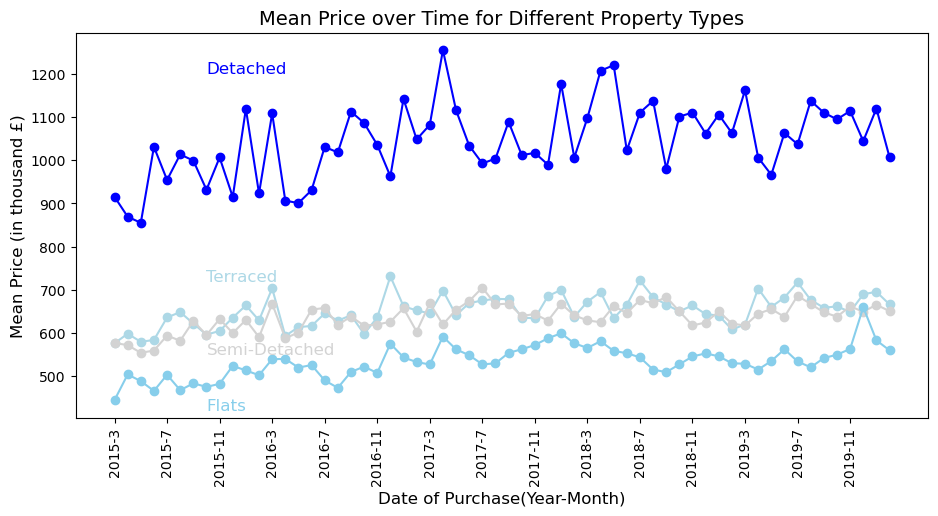

In [19]:
def plot_mean_price_over_time(df, property_types_to_keep, ax):
    color_map = {'D': 'blue', 'E': 'lightblue', 'F': 'skyblue', 'S': '#D3D3D3'}
    # Loop over each property type
    for prop_type in property_types_to_keep:
        df_filtered = df[df['Property_Type'] == prop_type].copy()
        # Convert 'Date_of_Transfer' to datetime
        df_filtered['Date_of_Transfer'] = pd.to_datetime(df_filtered['Date_of_Transfer'])
        # Extract year and month from 'Date_of_Transfer'
        df_filtered['Year'] = df_filtered['Date_of_Transfer'].dt.year
        df_filtered['Month'] = df_filtered['Date_of_Transfer'].dt.month
        # Group by year and month, calculate the mean price for each group
        grouped_df = df_filtered.groupby(['Year', 'Month'])['price'].mean().reset_index()
        # Convert price to thousands of pounds
        grouped_df['price'] /= 1000
        line_color = color_map.get(prop_type, 'lightblue')  
        ax.plot(grouped_df['Year'].astype(str) + '-' + grouped_df['Month'].astype(str), grouped_df['price'], marker='o', linestyle='-', label=prop_type, color=line_color)
        # Add labels on the lines
        if prop_type == 'D':
            ax.text('2015-10', 1200, 'Detached', fontsize=12, color=line_color)
        elif prop_type == 'T':
            ax.text('2015-10', 720, 'Terraced', fontsize=12, color=line_color)
        elif prop_type == 'S':
            ax.text('2015-10', 550, 'Semi-Detached', fontsize=12, color=line_color)
        elif prop_type == 'F':
            ax.text('2015-10', 420, 'Flats', fontsize=12, color=line_color)
    ax.set_xlabel('Date of Purchase(Year-Month)', fontsize=12)  # Reduced fontsize for axis label
    ax.set_ylabel('Mean Price (in thousand £)', fontsize=12)  # Reduced fontsize for axis label
    ax.set_title('Mean Price over Time for Different Property Types', fontsize=14)  # Reduced fontsize for title
    ax.tick_params(axis='x', rotation=90)  # Rotate x-axis labels
    ax.set_xticks(ax.get_xticks()[::4])
fig, ax = plt.subplots(figsize=(11, 5))
plot_mean_price_over_time(df, ['D', 'T', 'S', 'F'], ax)
plt.show()

This graph displays the average price of property sold for different types of housing. The figure clearly indicates that Detached houses are usually more expensive and purchase values experience more volatility if one compares them to Flats, Semi-detached or Terraced houses. The average price mostly increase from March 2016 and peaks in March 2017. There is another spike for detached houses between November 2017 and May 2018. There is little difference between Terraced and Semi-Detached Houses, however, Flats were sold at the lowest price on average.

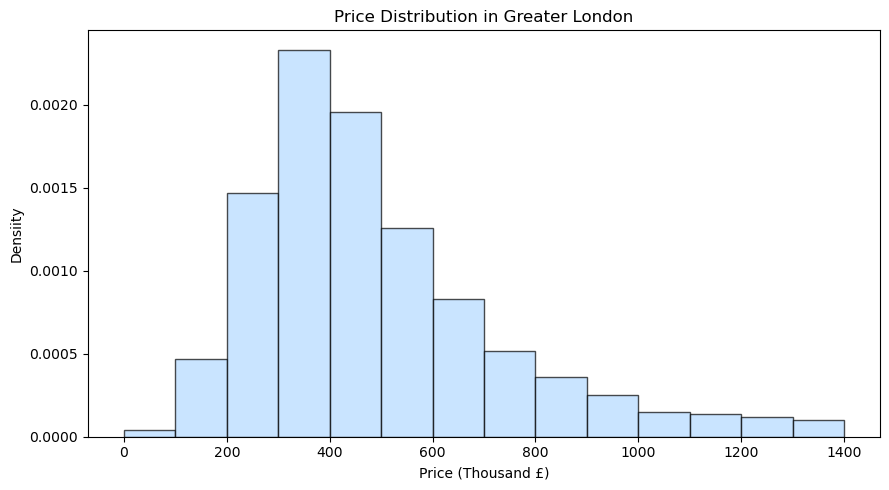

In [20]:
# Determine the 95th percentile of prices to identify outliers
price_95th_percentile = df['price'].quantile(0.95)
# Filter the DataFrame to exclude outliers
df_filtered = df[df['price'] <= price_95th_percentile].copy()  # Ensure copy of DataFrame is made
# Convert prices to thousands for the filtered data
df_filtered.loc[:, 'price_thousands'] = df_filtered['price'] / 1000  # Use .loc[] for assignment
# Determine the minimum and maximum prices in the filtered dataset (in thousands)
min_price = df_filtered['price_thousands'].min()
max_price = df_filtered['price_thousands'].max()
bin_edges = list(range(int(min_price), int(max_price) + 100, 100)) 
plt.figure(figsize=(9, 5))
plt.hist(df_filtered['price_thousands'], bins=bin_edges, color='#b3d9ff', edgecolor='black', alpha=0.7, density=True)
plt.xlabel('Price (Thousand £)')
plt.ylabel('Densiity')
plt.title('Price Distribution in Greater London')
plt.tight_layout()
plt.show()

This figure clearly displays distribution of property prices that were sold just in Greater London Area between March 2015 and March 2020. The chart is definitely skewed to the right and indicates that most purchases were lower than median and under the value of 800 thousand pounds. The spike in the price range between 300 and 400 thousand pounds indicates that this was the most frequent value paid for the property.

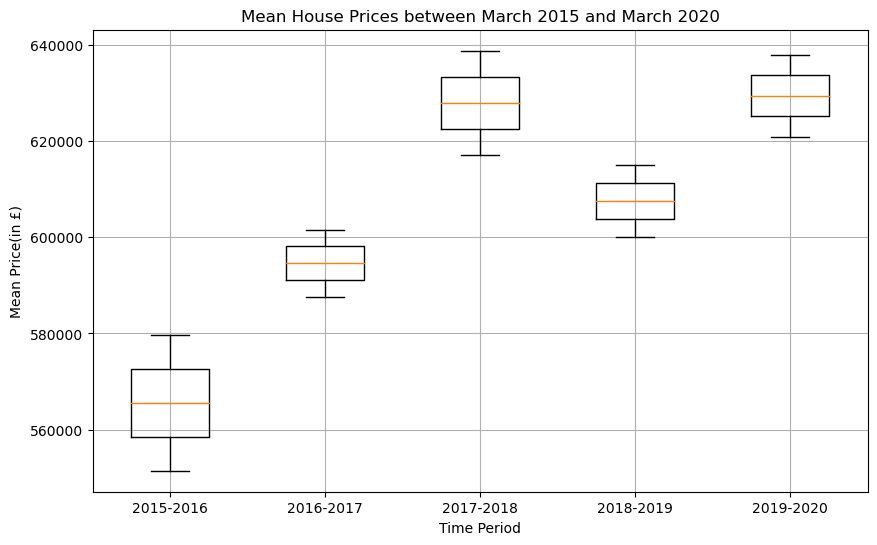

In [21]:
# Time periods from March of one year to March of the next year(exclusive)
df_2015_2016 = df[(df['Year_of_Transfer'] >= 2015) & (df['Year_of_Transfer'] <= 2016) & ((df['Year_of_Transfer'] == 2015) & (df['Month_of_Transfer'] >= 3) | (df['Year_of_Transfer'] == 2016) & (df['Month_of_Transfer'] < 3))]
df_2016_2017 = df[(df['Year_of_Transfer'] >= 2016) & (df['Year_of_Transfer'] <= 2017) & ((df['Year_of_Transfer'] == 2016) & (df['Month_of_Transfer'] >= 3) | (df['Year_of_Transfer'] == 2017) & (df['Month_of_Transfer'] < 3))]
df_2017_2018 = df[(df['Year_of_Transfer'] >= 2017) & (df['Year_of_Transfer'] <= 2018) & ((df['Year_of_Transfer'] == 2017) & (df['Month_of_Transfer'] >= 3) | (df['Year_of_Transfer'] == 2018) & (df['Month_of_Transfer'] < 3))]
df_2018_2019 = df[(df['Year_of_Transfer'] >= 2018) & (df['Year_of_Transfer'] <= 2019) & ((df['Year_of_Transfer'] == 2018) & (df['Month_of_Transfer'] >= 3) | (df['Year_of_Transfer'] == 2019) & (df['Month_of_Transfer'] < 3))]
df_2019_2020 = df[(df['Year_of_Transfer'] >= 2019) & (df['Year_of_Transfer'] <= 2020) & ((df['Year_of_Transfer'] == 2019) & (df['Month_of_Transfer'] >= 3) | (df['Year_of_Transfer'] == 2020) & (df['Month_of_Transfer'] < 3))]

#mean prices for each year
mean_prices_2015_2016 = df_2015_2016.groupby('Year_of_Transfer')['price'].mean()
mean_prices_2016_2017 = df_2016_2017.groupby('Year_of_Transfer')['price'].mean()
mean_prices_2017_2018 = df_2017_2018.groupby('Year_of_Transfer')['price'].mean()
mean_prices_2018_2019 = df_2018_2019.groupby('Year_of_Transfer')['price'].mean()
mean_prices_2019_2020 = df_2019_2020.groupby('Year_of_Transfer')['price'].mean()

#box plots for each year
plt.figure(figsize=(10, 6))
plt.boxplot([
    mean_prices_2015_2016,
    mean_prices_2016_2017,
    mean_prices_2017_2018,
    mean_prices_2018_2019,
    mean_prices_2019_2020
], labels=['2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020'])

#box plot
plt.title('Mean House Prices between March 2015 and March 2020')
plt.xlabel('Time Period')
plt.ylabel('Mean Price(in £)')
plt.grid(True)

plt.show()

This box plot demonstrates general change in the prices of the property sold based on intervals and independent of other variables. The average price of property sold increased each year, except time period between March 2018 and March 2019, when it clearly dropped. There was more variability in prices paid between March 2015 and March 2016 compared to other years, whereas time periods between 2016 and 2017 or 2018 and 2019 indicate that monthly average prices paid are closer to the median values. All values fall in range between 550 and 650 thousand pounds.

In [22]:
# Calculate percentage change of mean price from one interval to the other
grouped_df['Price_Mean_Percent_Change'] = grouped_df['Price_Mean'].pct_change() * 100
mean_percent_change = grouped_df.groupby(['Interval', 'Old/New'])['Price_Mean_Percent_Change'].mean().reset_index()
mean_percent_change.rename(columns={'Price_Mean_Percent_Change': 'Mean_Percent_Change'}, inplace=True)

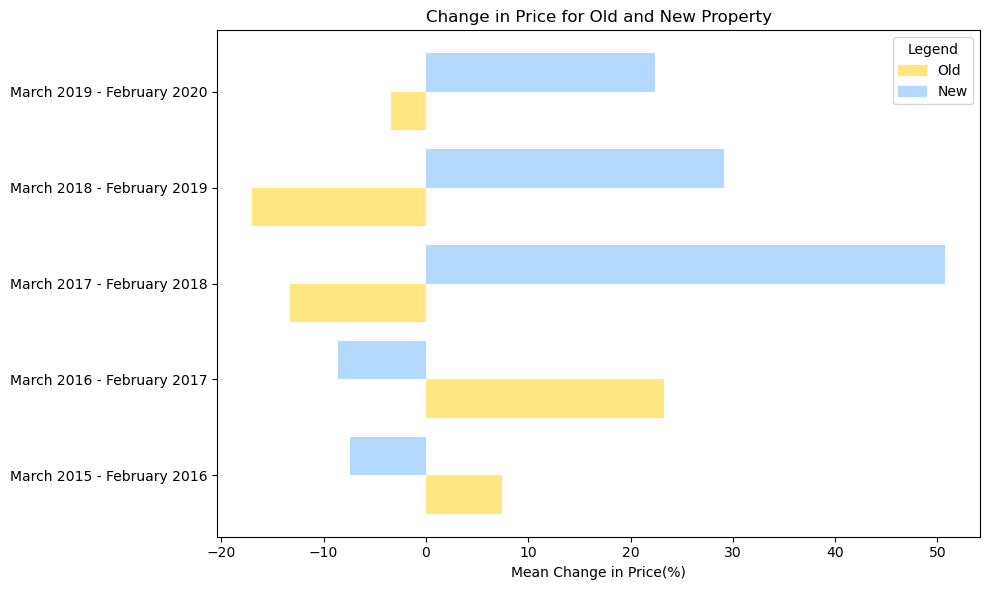

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
interval_order = mean_percent_change['Interval'].unique()
# Set colors for N and Y bars
colors = {'Y': '#b3d9ff', 'N': '#ffe680'}

bar_width = 0.4

for i in range(len(interval_order)):
    interval = interval_order[i]
    interval_data = mean_percent_change[mean_percent_change['Interval'] == interval]
    n_values = interval_data[interval_data['Old/New'] == 'N']['Mean_Percent_Change'].values
    y_values = interval_data[interval_data['Old/New'] == 'Y']['Mean_Percent_Change'].values
    ax.barh([i - bar_width / 2] * len(n_values), n_values, height=bar_width, color=colors['N'], label='N')
    ax.barh([i + bar_width / 2] * len(y_values), y_values, height=bar_width, color=colors['Y'], label='Y')
    
ax.set_yticks(range(len(interval_order)))
ax.set_yticklabels(interval_order)

legend_handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in ['N', 'Y']]
ax.legend(legend_handles, ['Old', 'New'], title='Legend')


ax.set_xlabel('Mean Change in Price(%)')
ax.set_title('Change in Price for Old and New Property')

plt.tight_layout()
plt.show()

This graph compares the growth rates for prices of old and new property purchases. When there was a positive change in the price paid for one type of property, the other type experienced a decrease. Newly-built properties have seen the highest spike in prices paid of almost 50% growth between March 2017 and March 2018, with relatively high growth during consecutive intervals, though at a decreasing rate.

In [97]:
import geopandas as gpd

file_path = "/Users/user/Desktop/ECO225/ECO225Project/Data/London-wards-2018/London-wards-2018_ESRI/London_Ward_CityMerged.shp"
district_df = gpd.read_file(file_path)

district_df.head()

,NAME,GSS_CODE,DISTRICT,LAGSSCODE,HECTARES,NONLD_AREA,geometry
0,Chessington South,E05000405,Kingston upon Thames,E09000021,755.173,0.0,"POLYGON ((516401.596 160201.802, 516407.302 16..."
1,Tolworth and Hook Rise,E05000414,Kingston upon Thames,E09000021,259.464,0.0,"POLYGON ((519552.998 164295.600, 519508.096 16..."
2,Berrylands,E05000401,Kingston upon Thames,E09000021,145.390,0.0,"POLYGON ((518107.499 167303.399, 518114.301 16..."
3,Alexandra,E05000400,Kingston upon Thames,E09000021,268.506,0.0,"POLYGON ((520336.700 165105.498, 520332.198 16..."
4,Beverley,E05000402,Kingston upon Thames,E09000021,187.821,0.0,"POLYGON ((521201.203 169275.505, 521204.303 16..."


In [98]:
print(district_df.columns)

Index(['NAME', 'GSS_CODE', 'DISTRICT', 'LAGSSCODE', 'HECTARES', 'NONLD_AREA',
       'geometry'],
      dtype='object')


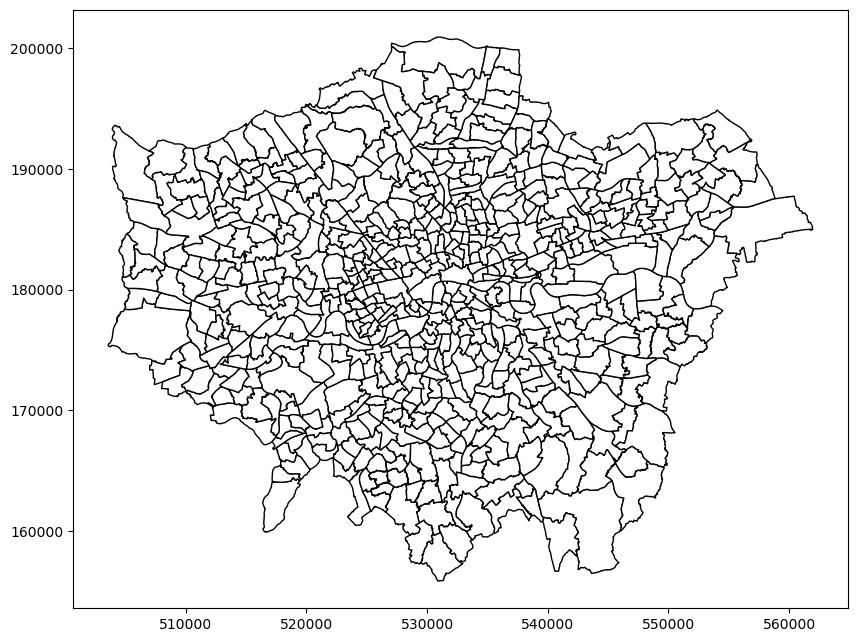

In [99]:
fig, gax = plt.subplots(figsize=(10, 10))
district_df.plot(ax=gax, edgecolor="black", color="white")
plt.show()

In [100]:
df_maps = df.groupby(['Interval', 'District'])['price'].mean()
df_maps = df_maps.reset_index()
df_maps = df_maps.rename(columns={'price': 'Price_Mean', 'District': 'DISTRICT'})
print(df_maps.tail())

                       Interval        DISTRICT     Price_Mean
160  March 2019 - February 2020       SOUTHWARK  657879.756857
161  March 2019 - February 2020          SUTTON  421882.690811
162  March 2019 - February 2020   TOWER HAMLETS  538613.380662
163  March 2019 - February 2020  WALTHAM FOREST  458897.401342
164  March 2019 - February 2020      WANDSWORTH  751739.913993


In [101]:
interval1 = 'March 2015 - February 2016'
interval2 = 'March 2019 - February 2020'
df_interval1 = df_maps[df_maps['Interval'] == interval1]
df_interval2 = df_maps[df_maps['Interval'] == interval2]

# Merge the two DataFrames based on the 'DISTRICT' column
merged_df = pd.merge(df_interval1, df_interval2, on='DISTRICT', suffixes=('_interval1', '_interval2'))

# Calculate the percentage change in price
merged_df['Percentage_Change'] = ((merged_df['Price_Mean_interval2'] - 
                                   merged_df['Price_Mean_interval1']) / merged_df['Price_Mean_interval1']) * 100

# Create a new DataFrame with 'DISTRICT' and 'Percentage_Change' columns
percentage_change_df = merged_df[['DISTRICT', 'Percentage_Change']]

# Display the new DataFrame
print(percentage_change_df)

                  DISTRICT  Percentage_Change
0     BARKING AND DAGENHAM          27.413722
1                   BARNET           8.253015
2                   BEXLEY          23.799058
3                    BRENT           9.622879
4                  BROMLEY          11.766344
5                   CAMDEN           5.597873
6           CITY OF LONDON          27.885740
7      CITY OF WESTMINSTER          29.600804
8                  CROYDON          24.470445
9                   EALING           3.171074
10                 ENFIELD          18.444935
11               GREENWICH          19.351871
12                 HACKNEY          21.432725
13  HAMMERSMITH AND FULHAM          -1.411756
14                HARINGEY          12.682889
15                  HARROW           4.947793
16                HAVERING          21.850249
17              HILLINGDON          10.509855
18                HOUNSLOW           7.719363
19               ISLINGTON           5.545725
20  KENSINGTON AND CHELSEA        

In [102]:
district_df["DISTRICT"] = district_df["DISTRICT"].str.title()
district_df["DISTRICT"] = district_df["DISTRICT"].str.strip()
# Corrected assignment using .loc
percentage_change_df.loc[:, "DISTRICT"] = percentage_change_df["DISTRICT"].str.title()
percentage_change_df.loc[:, "DISTRICT"] = percentage_change_df["DISTRICT"].str.strip()

In [104]:
districts = district_df.merge(percentage_change_df, left_on="DISTRICT", right_on="DISTRICT", how="inner")

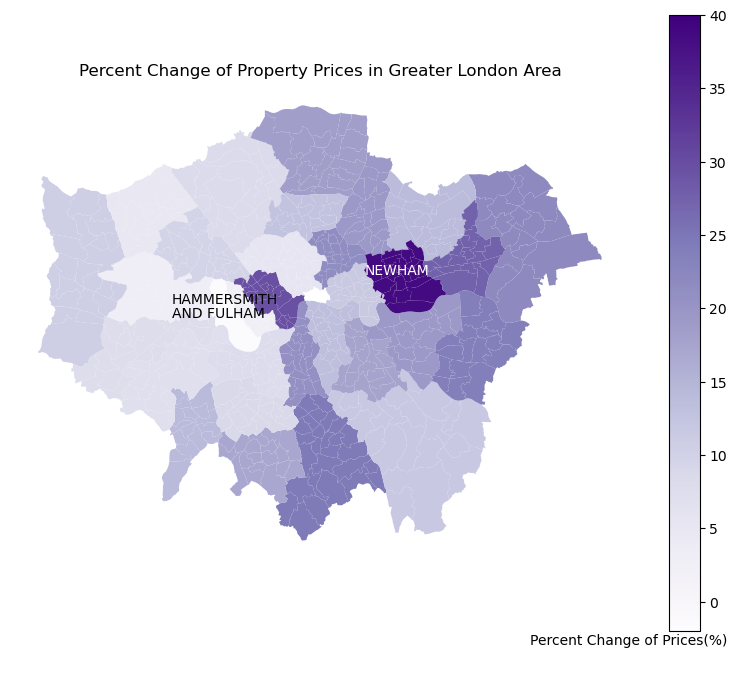

In [113]:
fig, gax = plt.subplots(figsize=(10, 8))

district_df.plot(ax=gax, edgecolor='white', color='white')

districts.plot(
    ax=gax, edgecolor='black', linewidth=0, column='Percentage_Change', legend=True, cmap='Purples',
    vmin=-2, vmax=40
)

label_coords = {'NEWHAM': (537000, 183000), 'HAMMERSMITH': (517000, 180000), 'AND FULHAM': (517000, 178500)}
for label, (lon, lat) in label_coords.items():
    color = 'white' if label == 'NEWHAM' else 'black'  
    gax.annotate(label, xy=(lon, lat), xycoords='data', xytext=(3, 3), 
                 textcoords='offset points', fontsize=10, color=color)

gax.annotate('Percent Change of Prices(%)', xy=(0.53, 0.055), xycoords='figure fraction')
gax.set_title("Percent Change of Property Prices in Greater London Area", fontsize=12)
plt.axis('off')
plt.show()

## Conclusion

In conclusion, this research highlights the nuanced dynamics of the housing market in the Greater London Area before and after the introduction of the First Time Buyers' Relief by the UK government. The analysis underscores significant disparities in price dynamics across property types, with detached houses consistently displaying higher prices compared to flats. While the overall average property prices experienced an upward trend over the five-year interval, a notable decline in mean prices was observed between March 2018 and March 2019. Despite the documentation of several high-value property transactions, the majority of properties sold were valued at less than 800 thousand pounds. These findings underscore the complex nature of housing market dynamics and suggest the need for further exploration to analyse the impact of targeted interventions that address affordability challenges and foster equitable access to housing.

## References

1. Bolster, A. (2011). Evaluating the Impact of Stamp Duty Land Tax First Time Buyer’s Relief.. https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=dbc6dd9a2a
67fcd3e76bd3ed699d3533de147d24
2. Bone, J., & O’Reilly, K. (2010). No place called home: the causes and social consequences of the UK housing 'bubble.' The British Journal of Sociology, 61(2), 231–255. https://doi.org/10.1111/j.1468-4446.2010.01311.x
3. HM Land Registry Open Data. (2023). Landregistry.data.gov.uk. https://landregistry.data.gov.uk/
4. Sabater, A., & Finney, N. (2022). Age segregation and housing unaffordability: Generational divides in housing opportunities and spatial polarisation in England and Wales. Urban Studies. https://doi.org/10.1177/00420980221121088
5. Szumilo, N. (2018). The spatial consequences of the housing affordability crisis in England. Environment and Planning A: Economy and Space, 51(6), 1264–1286. https://doi.org/10.1177/0308518x18811671